<a href="https://colab.research.google.com/github/Vurimindi2021/Capstone3/blob/main/src/nlp_contradictory_Bert_Base_ML_Cased250.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.flush_and_unmount()
drive.mount('/content/drive', force_remount=True)

Drive not mounted, so nothing to flush and unmount.
Mounted at /content/drive


In [ ]:
!pip install transformers
!pip install --quiet googletrans
!pip install dask[Bag]

     |████████████████████████████████| 2.6 MB 4.8 MB/s 
     |████████████████████████████████| 895 kB 34.0 MB/s 
     |████████████████████████████████| 636 kB 45.2 MB/s 
     |████████████████████████████████| 3.3 MB 53.6 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 55 kB 2.2 MB/s 
     |████████████████████████████████| 1.2 MB 10.9 MB/s 
     |████████████████████████████████| 42 kB 1.3 MB/s 
     |████████████████████████████████| 65 kB 2.9 MB/s 
     |████████████████████████████████| 53 kB 2.2 MB/s 
     |████████████████████████████████| 118 kB 5.4 MB/s 


In [ ]:
import os, datetime, math
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras.backend as K
import seaborn as sns
import matplotlib.pyplot as plt
from googletrans import Translator
from tensorflow.keras import callbacks
from transformers import BertTokenizer, TFBertModel
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from dask import bag, diagnostics
import tensorflow as tf
import tensorflow_hub as hub
import transformers
from transformers import AutoTokenizer
from contextlib import nullcontext

In [ ]:
chkpt_path = '/content/drive/MyDrive/nlp/check_point/bert_base_multilingual_cased250.h5'
log_path = os.path.join("/content/drive/MyDrive/nlp/logs/", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [ ]:
train = pd.read_csv("/content/drive/MyDrive/nlp/data/train.csv")
test = pd.read_csv("/content/drive/MyDrive/nlp/data/test.csv")

In [ ]:
batch_size  = 16                          # Batch Size
epochs      = 5                           # Number of Epochs in model.fit
train_size  = 12120                       # Number of Obs in Training Dataset
val_size    = 5195                        # Number of Obs in Validation Dataset
compute_steps_per_epoch = lambda x: int(math.ceil(1. * x / batch_size))
steps_per_epoch = compute_steps_per_epoch(train_size)
val_steps = compute_steps_per_epoch(val_size)

In [ ]:
model_name = 'bert-base-multilingual-cased'
tokenizer = BertTokenizer.from_pretrained(model_name)

In [ ]:
MAX_LENGTH=250
max_len=MAX_LENGTH*2

In [ ]:
def encode_sentence(s):
   return tokenizer.encode(s,padding='max_length', max_length=MAX_LENGTH,truncation=True)

In [ ]:
def bert_encode(hypotheses, premises, tokenizer):
    
  #num_examples = len(hypotheses)
  
  sentence1 = tf.ragged.constant([encode_sentence(s) for s in np.array(hypotheses)])
  sentence2 = tf.ragged.constant([encode_sentence(s) for s in np.array(premises)])

  #cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*sentence1.shape[0]
  input_word_ids = tf.concat([sentence1, sentence2], axis=-1)

  input_mask = tf.ones_like(input_word_ids).to_tensor()

  #type_cls = tf.zeros_like(cls)
  type_s1 = tf.zeros_like(sentence1)
  type_s2 = tf.ones_like(sentence2)
  input_type_ids = tf.concat(
      [type_s1, type_s2], axis=-1).to_tensor()

  inputs = {
      'input_word_ids': input_word_ids.to_tensor(),
      'input_mask': input_mask,
      'input_type_ids': input_type_ids}

  return inputs

In [ ]:
train_input = bert_encode(train.premise.values, train.hypothesis.values, tokenizer)

In [ ]:
test_input  = bert_encode(test.premise.values, test.hypothesis.values, tokenizer)

In [ ]:
def build_model():
    bert_encoder = TFBertModel.from_pretrained(model_name)
    input_word_ids = tf.keras.Input(shape=(max_len,),dtype=tf.int32, name="input_word_ids")
    input_mask = tf.keras.Input(shape=(max_len,),dtype=tf.int32, name="input_mask")
    input_type_ids = tf.keras.Input(shape=(max_len,),dtype=tf.int32, name="input_type_ids")
    
    embedding = bert_encoder([input_word_ids, input_mask, input_type_ids])[0]
    output = tf.keras.layers.Dense(3, activation='softmax')(embedding[:,0,:])
    
    model = tf.keras.Model(inputs=[input_word_ids, input_mask, input_type_ids], outputs=output)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'])
    return model


In [ ]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except ValueError:
    strategy = tf.distribute.get_strategy() # for CPU and single GPU
    print('Number of replicas:', strategy.num_replicas_in_sync)

INFO:absl:Entering into master device scope: /job:worker/replica:0/task:0/device:CPU:0


INFO:tensorflow:Initializing the TPU system: grpc://10.32.178.146:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.32.178.146:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [ ]:
with strategy.scope():
  model = build_model()
  model.summary()

Some layers from the model checkpoint at bert-base-multilingual-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-multilingual-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 500)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 500)]        0                                            
__________________________________________________________________________________________________
input_type_ids (InputLayer)     [(None, 500)]        0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     TFBaseModelOutputWit 177853440   input_word_ids[0][0]             
                                                                 input_mask[0][0]             

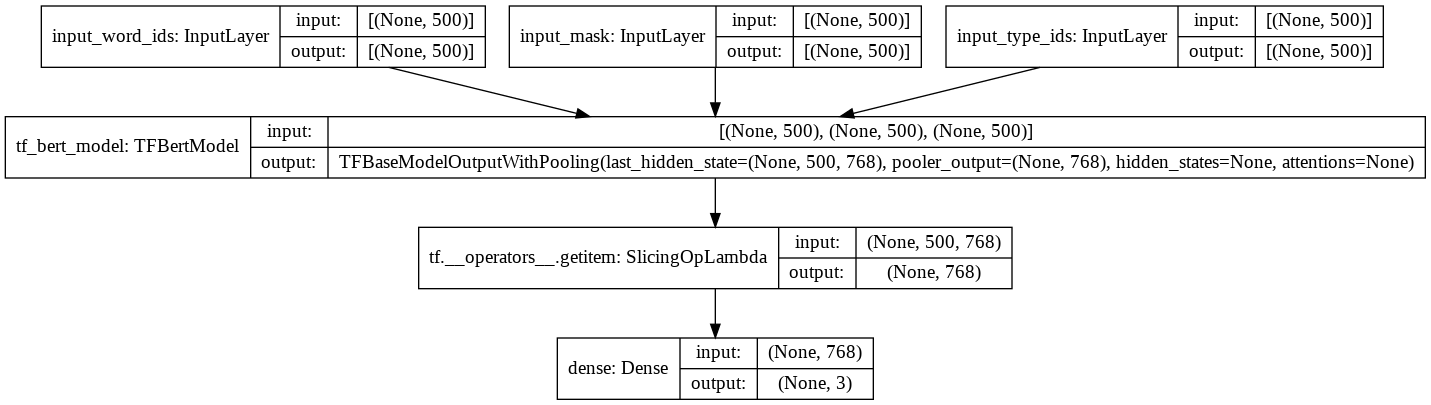

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True, to_file='/content/drive/MyDrive/nlp/figs/bert_base_multilingual_cased250.png')

In [ ]:
# saving model at best accuracy epoch
checkpoint = callbacks.ModelCheckpoint(filepath=chkpt_path,
                                    save_weights_only=True,
                                    monitor="val_sparse_categorical_accuracy",
                                    mode='max',
                                    verbose = 0,
                                    save_best_only=True,
                                    save_freq = "epoch")
earlystop = callbacks.EarlyStopping(monitor="val_sparse_categorical_accuracy", 
                                    min_delta=0.001, 
                                    patience=5, 
                                    verbose=1,
                                    mode='auto', 
                                    baseline=None, 
                                    restore_best_weights=False)

In [ ]:
history=model.fit(x=train_input, 
                  y=train.label.values, 
                  epochs=epochs,
                  verbose = 1, 
                  validation_split = 0.2,
                  batch_size=batch_size,
                  callbacks =[checkpoint])

Epoch 1/5


606/606 [==============================] - ETA: 0s - loss: 0.9569 - accuracy: 0.5274

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 500) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 500) dtype=int32>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None, 500) dtype=int32>, <tf.Tensor 'cond_8/Identity_3:0' shape=(None,) dtype=int64>]


606/606 [==============================] - 140s 131ms/step - loss: 0.9569 - accuracy: 0.5274 - val_loss: 0.8542 - val_accuracy: 0.6077
Epoch 2/5
606/606 [==============================] - 70s 116ms/step - loss: 0.7515 - accuracy: 0.6811 - val_loss: 0.7796 - val_accuracy: 0.6638
Epoch 3/5
606/606 [==============================] - 70s 115ms/step - loss: 0.5767 - accuracy: 0.7586 - val_loss: 0.8111 - val_accuracy: 0.6531
Epoch 4/5
606/606 [==============================] - 70s 116ms/step - loss: 0.4055 - accuracy: 0.8371 - val_loss: 1.0437 - val_accuracy: 0.6502
Epoch 5/5
606/606 [==============================] - 70s 116ms/step - loss: 0.2638 - accuracy: 0.8998 - val_loss: 1.1554 - val_accuracy: 0.6555


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


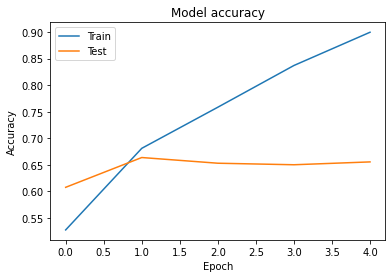

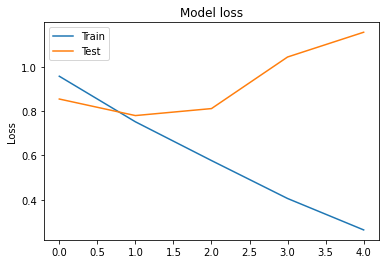

In [ ]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig(fname='/content/drive/MyDrive/nlp/figs/bert_ml_cased_model250_accuracy.png')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig(fname='/content/drive/MyDrive/nlp/figs/bert_ml_cased_model250_loss.png')
plt.show()


In [ ]:
predictions = [np.argmax(i) for i in model.predict(test_input)]

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 500) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 500) dtype=int32>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None, 500) dtype=int32>]


In [ ]:
submission = test.id.copy().to_frame()
submission['prediction'] = predictions
submission.head()
submission.to_csv("/content/drive/MyDrive/nlp/data/bert_ml_cased_model250.csv", index = False)